In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from strategy_tester import Backtesting
from model_loader import ModelLoader
from sklearn.metrics import classification_report

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4
    )

SELECCIÓN DEL MEJOR MODELO PRE-ENTRENADO

In [3]:
# Leer el archivo de métricas
metrics_path = '../../score_models/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')

# Encontrar el modelo con el mayor trend_change_f1_score
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")

# Construir la ruta del archivo del modelo
model_file = f'../../score_models/{best_model_name}.txt'

# Instanciar y cargar el modelo
loader = ModelLoader(best_model_name, model_file)
model = loader.load()
params = model.params


Mejor modelo según trend_change_f1_score: LightGBM


In [4]:
# Cargar datos
train = pd.read_csv("../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])

# Concatenar los dataframes de entrenamiento y validación
train_val_set = pd.concat([train, val], ignore_index=True)

CARGA Y PREPARACIÓN DE DATOS

In [5]:
# --- Limitar el test set para pruebas rápidas ---
# Para pruebas rápidas, puedes limitar el número de días. Para un backtest completo, usa todos los datos.
# n_days_to_test = 50 
# test_set = test_set_full.head(n_days_to_test).copy()

# Preparar los arrays de numpy para la clase Backtesting
# Se pasa el conjunto combinado. La división se hará dentro de la clase Backtesting.
X_train_val = train_val_set.drop(columns=["date", "target_trend"]).values
y_train_val = train_val_set["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

Ejecución del Backtesting con Walk-Forward Optimization

In [6]:
# 1. Configuración de parámetros del backtesting
initial_capital = 10000.0 # Capital inicial para la simulación
window_size = 5 # Número de días en cada ventana de prueba antes de re-optimizar.
optuna_trials_initial_step = 700 # Número de trials de Optuna en el primer paso (más intensivo).
optuna_trials_per_step = 200 # Número de trials para los pasos de re-optimización siguientes.

# 2. Instanciar la clase Backtesting con los datos y la configuración.
bt = Backtesting(
    best_model_name, # Se pasa el nombre del modelo a usar.
    X_train_val, y_train_val, X_test, y_test, test_set,
    window_size=window_size,
    initial_capital=initial_capital,
    optuna_trials_initial=optuna_trials_initial_step,
    optuna_trials=optuna_trials_per_step
)

# Ejecutar el método que contiene toda la lógica del backtesting
# Devuelve el historial de la cartera y métricas clave de la simulación.
backtest_df = bt.run()

# Extraer métricas de la estrategia principal para el análisis
num_buys = bt.num_buys_executed
num_sells = bt.num_sells_executed

# 3. Cálculo de los resultados finales de la estrategia principal.
final_portfolio_value = backtest_df['walk_forward_portfolio'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100


Walk-Forward Backtesting:   0%|          | 0/295 [00:00<?, ?it/s][I 2025-09-12 19:43:59,800] A new study created in memory with name: no-name-735c61bf-93a4-4bf8-b397-88aaa2790717
[I 2025-09-12 19:44:01,986] Trial 0 finished with value: 0.2077922077922078 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.2077922077922078.
[I 2025-09-12 19:44:02,626] Trial 1 finished with value: 0.275 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 1 with value: 0.275.
[I 2025-09-12 19:44:03,541] Trial 2 finished with value: 0.2682926829268293 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34, 'max_depth': 6, 'fe

In [15]:
print("\n--- Resultados del Backtesting (Walk-Forward Optimization) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"\nValor Final del Portafolio con Walk-Forward Optimization: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
buy_and_hold_portfolio_value = backtest_df['buy_and_hold_portfolio'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_portfolio_value - initial_capital) / initial_capital * 100
print(f"\nValor Final del Portafolio con Estrategia Buy & Hold: ${buy_and_hold_portfolio_value:,.2f}")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")
dca_portfolio_value = backtest_df['dca_portfolio'].iloc[-1]
dca_return_pct = (dca_portfolio_value - initial_capital) / initial_capital * 100
print(f"\nValor Final del Portafolio con Estrategia Dollar Cost Averaging (DCA): ${dca_portfolio_value:,.2f}")
print(f"Retorno de Dollar Cost Averaging (DCA): {dca_return_pct:.2f}%")


--- Resultados del Backtesting (Walk-Forward Optimization) ---
Capital Inicial: $10,000.00

Valor Final del Portafolio con Walk-Forward Optimization: $17,610.37
Retorno Total de la Estrategia: 76.10%

Valor Final del Portafolio con Estrategia Buy & Hold: $17,117.30
Retorno de Comprar y Mantener (Buy & Hold): 71.17%

Valor Final del Portafolio con Estrategia Dollar Cost Averaging (DCA): $13,273.72
Retorno de Dollar Cost Averaging (DCA): 32.74%


In [16]:
# 4. Análisis de Operaciones

print("\n--- Análisis de Operaciones Reales ---")
print(f"Número de COMPRAS ejecutadas: {num_buys}")
print(f"Número de VENTAS ejecutadas: {num_sells}")
print(f"Número total de transacciones: {num_buys + num_sells}")


--- Análisis de Operaciones Reales ---
Número de COMPRAS ejecutadas: 12
Número de VENTAS ejecutadas: 11
Número total de transacciones: 23


In [17]:
# 5. Métricas de Clasificación sobre todo el Backtest

# Extraer las predicciones y los valores reales del período de backtesting
y_pred_backtest = backtest_df['signal'].values
y_true_backtest = test_set.loc[backtest_df.index, 'target_trend'].values

print("\n--- Métricas de Clasificación del Backtest Completo ---")

# Reporte de clasificación estándar (predicción de tendencia -1, 0, 1)
print("\nReporte de Clasificación (Tendencia):")
print(classification_report(y_true_backtest, y_pred_backtest, digits=4, zero_division=0))

# Reporte de clasificación de cambio de tendencia (predicción de True/False)
print("\nReporte de Cambio de Tendencia:")
print(trend_changes_score(y_true_backtest, y_pred_backtest))


--- Métricas de Clasificación del Backtest Completo ---

Reporte de Clasificación (Tendencia):
              precision    recall  f1-score   support

          -1     0.8288    0.9485    0.8846        97
           0     0.1250    0.0385    0.0588        26
           1     0.9375    0.9593    0.9483       172

    accuracy                         0.8746       295
   macro avg     0.6304    0.6487    0.6306       295
weighted avg     0.8302    0.8746    0.8490       295


Reporte de Cambio de Tendencia:
              precision    recall  f1-score   support

       False     0.9272    0.9202    0.9237       263
        True     0.3636    0.3871    0.3750        31

    accuracy                         0.8639       294
   macro avg     0.6454    0.6536    0.6493       294
weighted avg     0.8678    0.8639    0.8658       294



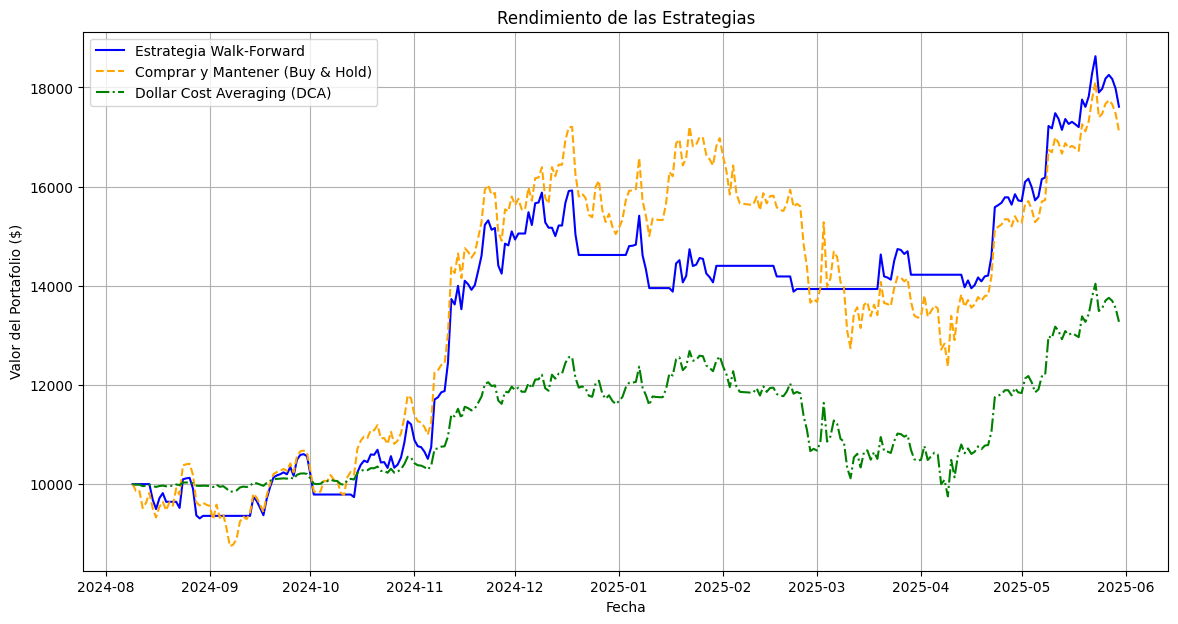

In [18]:
# 6. Visualización
plt.figure(figsize=(14, 7))

# Graficar las 3 estrategias directamente desde el DataFrame de resultados
plt.plot(backtest_df['date'], backtest_df['walk_forward_portfolio'], label='Estrategia Walk-Forward', color='blue')
plt.plot(backtest_df['date'], backtest_df['buy_and_hold_portfolio'], label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.plot(backtest_df['date'], backtest_df['dca_portfolio'], label='Dollar Cost Averaging (DCA)', color='green', linestyle='-.')

plt.title('Rendimiento de las Estrategias')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()